# Single Month Analysis

## Load in the data and model

In [1]:
import os 
import sys

sys.path.append('/home/kalkiek/projects/reddit-political-affiliation/')

import itertools
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm.notebook import tqdm

from src.data.make_dataset import build_dataset
from src.models.word2vec.User2Subreddit import User2Subreddit
# from src.models.word2vec.predict_model import predict_user_affiliations, top_n_similar_embeddings, \
#     save_similar_embeddings_to_tsv

from sklearn.metrics import auc, roc_curve

In [3]:
year_month = '2019-01'

network_path = '/shared/0/projects/reddit-political-affiliation/data/bipartite-networks/' + year_month + '_filtered.tsv'
flair_directory =  '/shared/0/projects/reddit-political-affiliation/data/flair-affiliations/' + year_month + '.tsv'

dataset, training, validation, pol_validation, vocab = build_dataset(network_path, flair_directory)


Building vocab from file:  49%|████▉     | 13189724/26729161 [00:26<00:19, 711159.95it/s]


Building vocab from file:  93%|█████████▎| 24964303/26729161 [00:50<00:03, 578974.35it/s]


Converting data to PyTorch:   0%|          | 240/5120865 [00:00<35:43, 2389.03it/s]

Length of vocab: 5178863
User count: 5120865
Subreddit count: 57998
User to politic counts: 2633
[('Cord_inate8', Counter({'Republican': 2})), ('error404brain', Counter({'Democrat': 1})), ('OTIS_is_king', Counter({'Democrat': 1})), ('Nesano', Counter({'Republican': 1})), ('SinisterPaige', Counter({'Republican': 1})), ('grubas', Counter({'Republican': 1})), ('DrPiccoloPhD', Counter({'Republican': 1})), ('Hillarys_cellmate', Counter({'Republican': 2})), ('guanaco55', Counter({'Republican': 2})), ('nycola', Counter({'Democrat': 1}))]
Saw political affiliations for 2632 users
User to politics training size: {}: 2369
User to politics validation size: {}: 263


Converting data to PyTorch: 100%|██████████| 5120865/5120865 [07:30<00:00, 11361.14it/s]


Train size: 144337470 Validation size: 16037496


In [4]:
# We'll need these later
word_to_ix = {word: i for i, word in enumerate(vocab)}
all_subreddits = {v for v in vocab if v[:2] == 'r/' and v[2:4] != 'u_'}
print("# of subreddits: " + str(len(all_subreddits)))

PATH = '/shared/0/projects/reddit-political-affiliation/working-dir/word2vec-outputs/' + year_month + '/9.pt'
embedding_dim = 50

# Sorry for the hardcoding ... will update later
device = torch.device("cuda:4")
model = User2Subreddit(5138256, embedding_dim, 80881)
model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()

# of subreddits: 55204


User2Subreddit(
  (u_embeddings): Embedding(5138256, 50)
  (v_embeddings): Embedding(80881, 50)
  (political_layer): Linear(in_features=50, out_features=1, bias=True)
  (before_pol_dropout): Dropout(p=0.5, inplace=False)
)

### Question 1 - Are most users left leaning or right leaning

In [5]:
def predict_user_affiliations(model, dataset):
    user_predictions = {}
    loader = DataLoader(dataset, batch_size=512)

    idx_to_user = {v: k for k, v in dataset.user_to_idx.items()}

    for i, data in enumerate(tqdm(loader, desc="Predicting user politics", total=len(dataset) / 512)):
        user_sub, politics_labels, subreddit_labels = data
        user_ids = user_sub[:, 0].to(device)
        subreddit_ids = user_sub[:, 1].to(device)
        
        _, pol_preds = model(user_ids, subreddit_ids, political_user_ids=user_ids)
        
        user_ids = user_ids.cpu().detach().numpy()
        pol_preds = pol_preds.cpu().detach().numpy()

        for j in range(len(user_ids)):
            user = idx_to_user[user_ids[j]]
            user_predictions[user] = pol_preds[j][0]

        
    return user_predictions

user_predictions = predict_user_affiliations(model, dataset)

### Save the predictions for later

In [20]:
out_dir = '/shared/0/projects/reddit-political-affiliation/data/word2vec/predictions/users_' + year_month + '.tsv'

with open(out_dir, 'w') as f:
    for user, score in user_predictions.items():
        f.write("{}\t{}\n".format(user, score))

### Load in previous predictions

In [25]:
in_dir = '/shared/0/projects/reddit-political-affiliation/data/word2vec/predictions/users_' + year_month + '.tsv'
user_predictions = {}

with open(in_dir, 'r') as f:
    for line in f:
        user, score = line.split('\t')
        user_predictions[user] = float(score.strip())

In [26]:
user_predictions

{'themsfactsjack': 0.999995231628418,
 'Pokenois_': 0.9999312162399292,
 'shingofan': 0.9961737990379333,
 'bethanyk98': 0.9992110729217529,
 'Growupandflyaway': 0.004579010419547558,
 'Passtheboof1': 0.9999279975891113,
 'fumez23': 1.0,
 'James_Locke': 0.9999926090240479,
 'Joonlar': 7.497071692341706e-07,
 'Cujo31rvw': 0.9949648380279541,
 'CajunBoi69': 0.99872225522995,
 'zaywolfe': 0.9998794794082642,
 'CrossfitSmurf': 0.32138219475746155,
 'Oceansize757': 0.999678373336792,
 'Sam18840': 0.9964518547058105,
 'never-give-up-': 0.9988333582878113,
 'ruddboy': 0.9962422847747803,
 'Gishnu': 1.0,
 'White667': 0.007092676591128111,
 'The_Bran_9000': 0.9996128678321838,
 'biglambda': 2.415923994192326e-08,
 'JellyRollGeorge': 0.9827293157577515,
 'sriracha_ketchup': 0.9998501539230347,
 'kensal78': 1.485604570916621e-06,
 'heytherelife': 0.9999967813491821,
 'ComeOnMisspellingBot': 0.39498135447502136,
 'clean_Iguess': 2.722199042182183e-06,
 'mwalke5': 1.0,
 'marieannfortynine': 0.99201

In [27]:
threshold = 0.5
left_count, right_count = 0., 0.

for user, prediction in user_predictions.items():    
    if prediction >= threshold:
        right_count += 1
    else:
        left_count += 1
        
total = len(user_predictions)
percent_right = right_count / total
percent_left = left_count / total

print("Percent of users left leaning: {}".format(percent_left))
print("Percent of users right leaning: {}".format(percent_right))

Percent of users left leaning: 0.11055651730713463
Percent of users right leaning: 0.8894434826928653


### Question 2 - Political Leanings of Major Subreddits

Find the top left and right subreddits

In [28]:
from src.data.make_dataset import build_user_to_subreddits

user_subreddits, vocab, all_subreddits = build_user_to_subreddits(network_path)


Building vocab from file:  47%|████▋     | 12591908/26729161 [01:04<00:20, 702622.75it/s]


Building vocab from file:  91%|█████████ | 24315169/26729161 [01:57<00:04, 568987.85it/s]


Building vocab from file: 100%|██████████| 26729161/26729161 [02:16<00:00, 196268.12it/s]


Length of vocab: 5178863
User count: 5120865
Subreddit count: 57998


In [32]:
from collections import defaultdict, Counter

# Number of scores a subreddit needs before we include it in this analysis
MIN_POST_THRESHOLD = 1000

subreddit_scores = defaultdict(lambda:0)
subreddit_counts = Counter()
subreddit_users = defaultdict(set)


for user, prediction in user_predictions.items():
    subreddits = user_subreddits[user]
    for sub in subreddits:
        if sub[2:4] != 'u_':
            subreddit_scores[sub] += prediction
            subreddit_counts[sub] += 1
            subreddit_users[sub].add(user)
            
        
norm_sub_scores = {}

for sub, score in subreddit_scores.items():
    count = subreddit_counts[sub]
    if count >= MIN_POST_THRESHOLD:
        norm_sub_scores[sub] = score / count
    

sorted_sub_scores = {k: v for k, v in sorted(norm_sub_scores.items(), key=lambda item: item[1], reverse=True)}
top_results = dict(itertools.islice(sorted_sub_scores.items(), 50))

print("Top 50 right leaning subreddits")

for sub, score in top_results.items():
    print(sub, score, subreddit_counts[sub])

Top 50 right leaning subreddits
r/Roleplaykik 0.9240981069055023 1468
r/dirtykikpals 0.9161041877665657 5469
r/EggsIncCoOp 0.9076454652538279 1170
r/AgeplayPenPals 0.9062013731702576 2055
r/DirtySnapchat 0.9017749920828636 2026
r/GaySnapchat 0.9011368754309173 1672
r/RandomActsOfMuffDive 0.9010119933594888 2337
r/YouTubeGamers 0.9009951594563226 1073
r/education 0.9007316760875422 1433
r/Gonewild18 0.8993287743528235 1078
r/shamelessplug 0.8978490571038218 1191
r/dirtypenpals 0.8972606262035164 5640
r/YouTube_startups 0.8969449974811615 3365
r/BDSMpersonals 0.8965391866076418 1410
r/Duklock 0.8951254878811147 1658
r/Gaykikpals 0.8944668566051643 1077
r/dirtyr4r 0.893905502187637 7558
r/discordservers 0.8936414831170566 1334
r/Sub4Sub 0.8931652616984739 1193
r/Kikpals 0.8917499094441967 1197
r/shareyourmusic 0.8917398757240911 1433
r/BlockChain 0.8912304077370087 1108
r/ksi 0.8902646016335805 5791
r/PokemonGoFriends 0.8902406938421168 1224
r/SmallYTChannel 0.8901476632328155 3036
r/Smal

In [33]:
sorted_sub_scores = {k: v for k, v in sorted(norm_sub_scores.items(), key=lambda item: item[1])}
top_results = dict(itertools.islice(sorted_sub_scores.items(), 100))

print("Top 50 left leaning subreddits")

for sub, score in top_results.items():
    print(sub, score, subreddit_counts[sub])

Top 50 left leaning subreddits
r/hmmtodayiwill 0.8028476733088162 1158
r/restofthefuckingowl 0.8031506646361734 1252
r/AgainstHateSubreddits 0.8035097698094317 1249
r/FragileWhiteRedditor 0.8041012941811424 1249
r/heck 0.8048200337362331 1337
r/ComedyNecrophilia 0.8048222058285203 1417
r/comedynecromancy 0.8051399121351789 1883
r/DecreasinglyVerbose 0.8054857250146866 1031
r/ShitWehraboosSay 0.8055757157199622 1194
r/toosoon 0.8062507368941617 1218
r/ItemShop 0.8065149454489272 1046
r/startrekgifs 0.8071256695653425 1097
r/delusionalcraigslist 0.8078234728045216 2168
r/RussiaLago 0.8083532495514404 2511
r/KenM 0.8088681223562004 1146
r/HaveWeMet 0.8094783326962108 1635
r/upvoteexeggutor 0.8098927421902051 1178
r/ProperAnimalNames 0.8100863863601699 1420
r/RoughRomanMemes 0.8104053617482756 1432
r/suddenlysexoffender 0.810557338421464 1243
r/killthosewhodisagree 0.8108641290070902 1050
r/gravityfalls 0.8113997758144824 1213
r/jesuschristreddit 0.8115317048507641 1609
r/gunpolitics 0.811

### Question 3 - Political Distribution of Major Subreddits

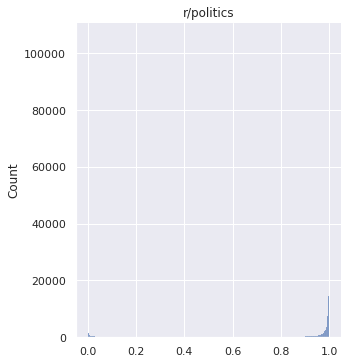

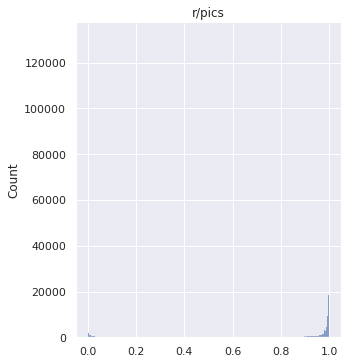

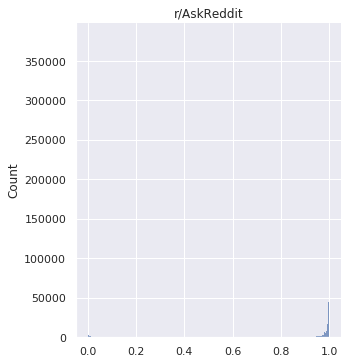

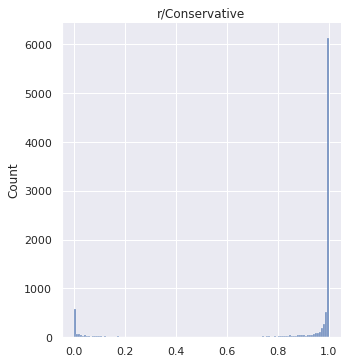

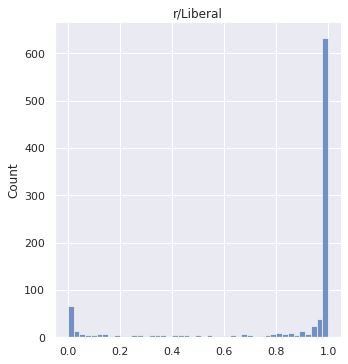

In [36]:
import seaborn as sns

major_subreddits = ['r/politics', 'r/pics', 'r/AskReddit', 'r/Conservative', 'r/Liberal']

def plot_sub_scores(subreddit, subreddit_users):
    sns.set_theme(style="darkgrid")
    scores = []
    
    for user in subreddit_users[subreddit]:
        scores.append(user_predictions[user])
        
    sns.displot(scores).set(title=subreddit)
#     sns.plt.xlim(0, 1)
#     sns.plt.set_title(subreddit)
#     sns.plt.show()

for sub in major_subreddits:
    plot_sub_scores(sub, subreddit_users)